In [158]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "./elder.jpg"
image = Image.open(url)

inputs = processor(text=['a photo of a girl',"a photo of a cat", "a photo of a dog",'a photo of a sparrow','a photo of a deer'], images=image, return_tensors="pt", padding=True)
list(inputs)
inputs['input_ids']


outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

list(probs)

[tensor([0.9465, 0.0083, 0.0295, 0.0092, 0.0064], grad_fn=<UnbindBackward0>)]

In [176]:
# from transformers import CLIPProcessor, CLIPModel,PreTrainedTokenizerFast
from transformers import PreTrainedTokenizerFast, CLIPProcessor, CLIPModel,CLIPTokenizerFast
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
("mps" if torch.backends.mps.is_available() else "cpu")

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

model = CLIPModel. from_pretrained(model_id) . to(device)
tokenizer = CLIPTokenizerFast. from_pretrained(model_id)
processor = CLIPProcessor. from_pretrained(model_id)

In [177]:
inputs =tokenizer("elder",return_tensors='pt')
inputs
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [178]:
url = "./deer.jpg"

image = processor(
text=None,
images=Image.open(url),
return_tensors="pt"
) ['pixel_values']. to(device)
image. shape

torch.Size([1, 3, 224, 224])

In [179]:

img_emb = model.get_text_features(**inputs)
img_emb.shape

torch.Size([1, 512])

In [180]:
images =[Image.open('./deer.jpg'),Image.open('./hill.jpg'),Image.open('./girl.jpg'),Image.open('./elder.jpg'),Image.open('./elder2.jpg')]

In [181]:
from tqdm.auto import tqdm
import numpy as np

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(5, 512)

In [182]:
image_arr.min(), image_arr.max()


(-7.379847, 2.3545187)

In [183]:

image_arr = image_arr / np.linalg.norm(image_arr, axis=0)
image_arr.min(), image_arr.max()

(-0.9823596, 0.9737364)

In [184]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 5)

In [185]:
top_k = 5
# get the top k indices for most similar vecs
idx = np.argsort(-scores[0])[:top_k]
idx

array([4, 3, 1, 2, 0], dtype=int64)

4: 14.415254592895508


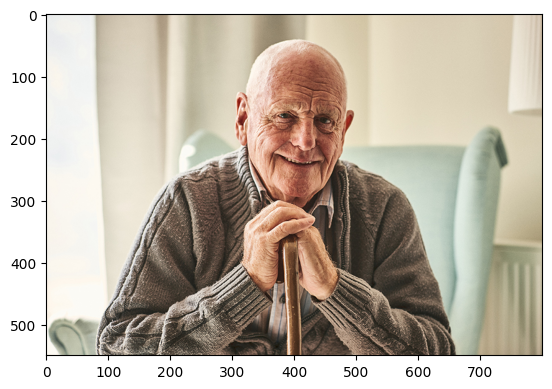

3: 12.366472244262695


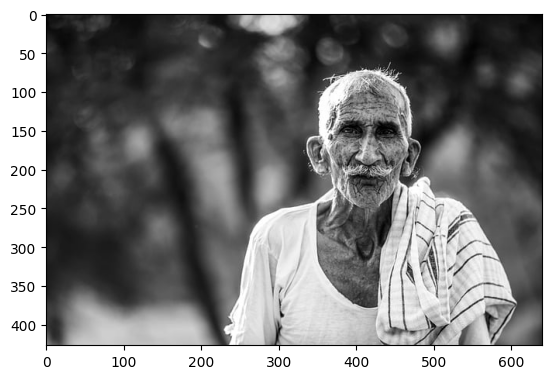

1: 9.478793144226074


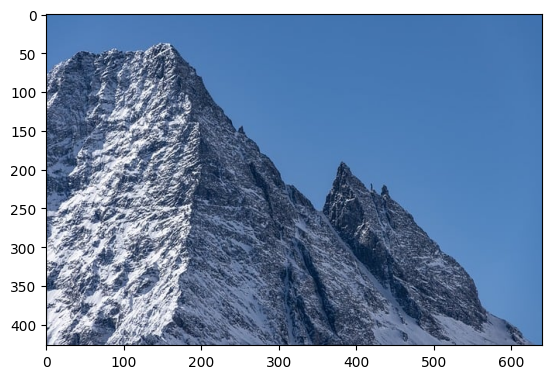

2: 6.198574066162109


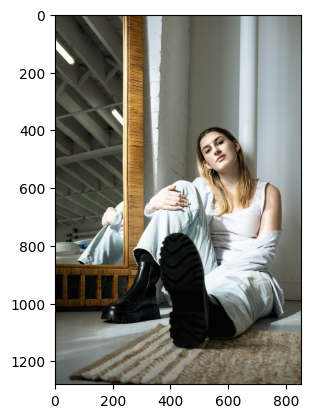

0: 2.2107574939727783


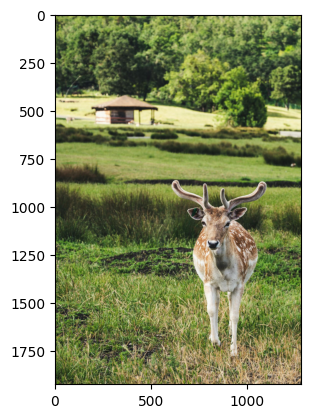

In [186]:
import matplotlib.pyplot as plt

# display the results
for i in idx:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()
